# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [3]:
# create engine to ev_db.sqlite
engine = create_engine("sqlite:///oil_price_interest_db.sqlite")


In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)
# View all of the classes that automap found
Base.classes.keys()

['CadRates', 'FedRates', 'crude_oil_prices']

In [5]:
# Save references to each table using correct case
crude_oil_prices = Base.classes.crude_oil_prices  
cad_rates = Base.classes.CadRates
fed_rates = Base.classes.FedRates

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Data loading 

In [7]:
# Import required libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.linear_model import LinearRegression
import sklearn as skl


In [8]:
min_year_WTI = session.query(func.min(crude_oil_prices.Year)).filter(crude_oil_prices.WTI.isnot(None)).scalar()
max_year_WTI = session.query(func.max(crude_oil_prices.Year)).filter(crude_oil_prices.WTI.isnot(None)).scalar()
min_year_WCS = session.query(func.min(crude_oil_prices.Year)).filter(crude_oil_prices.WCS.isnot(None)).scalar()
max_year_WCS = session.query(func.max(crude_oil_prices.Year)).filter(crude_oil_prices.WCS.isnot(None)).scalar()
min_year_fed = session.query(func.min(fed_rates.Year)).scalar()
min_year_cad = session.query(func.min(cad_rates.Year)).scalar()
print(f"Minimum Year (WTI not null): {min_year_WTI}")
print(f"Maximum Year (WTI not null): {max_year_WTI}")
print(f"Minimum Year (WCS not null): {min_year_WCS}")
print(f"Maximum Year (WCS not null): {max_year_WCS}")
print (f'min year in cad dataset :{min_year_cad}, minimun year in fed dataset: {min_year_fed}')

Minimum Year (WTI not null): 1986
Maximum Year (WTI not null): 2025
Minimum Year (WCS not null): 2005
Maximum Year (WCS not null): 2025
min year in cad dataset :2014, minimun year in fed dataset: 2012


In [9]:
# Query for crude oil prices WCS
crude_oil_prices_cad = session.query(
    crude_oil_prices.Year,
    crude_oil_prices.Month,
    crude_oil_prices.WCS,
).filter(
    crude_oil_prices.Year >= 2014,
    crude_oil_prices.Year <= 2024
).all()

# Convert the crude oil prices query result to a DataFrame
df_1 = pd.DataFrame(crude_oil_prices_cad, columns=['Year', 'Month', 'WCS'])

In [10]:
# Query for CAD rates
cad_rate = session.query(
    cad_rates.Year,
    cad_rates.Month,
    cad_rates.Inflation,
    cad_rates.Ten_Year_Bond_Yield,
    cad_rates.Overnight_Rate
).filter(
    cad_rates.Year >= 2014,
    cad_rates.Year <= 2024
).all()

# Convert the CAD rates query result to a DataFrame
df_2 = pd.DataFrame(cad_rate, columns=['Year', 'Month', 'Inflation', 'Ten_Year_Bond_Yield', 'Overnight Rate'])


In [11]:
#merge df_1 and df_2 based on Year Month
crude_oil_cad = pd.merge(df_1, df_2, on=['Year', 'Month'], how='inner')


In [12]:
# Query for crude oil prices WTI
crude_oil_prices_cad = session.query(
    crude_oil_prices.Year,
    crude_oil_prices.Month,
    crude_oil_prices.WTI,
).filter(
    crude_oil_prices.Year >= 2014,
    crude_oil_prices.Year <= 2024
).all()

# Convert the crude oil prices query result to a DataFrame
df_3 = pd.DataFrame(crude_oil_prices_cad, columns=['Year', 'Month', 'WTI'])

In [13]:
# Query for Fed rates
fed_rate = session.query(
    fed_rates.Year,
    fed_rates.Month,
    fed_rates.Inflation,
    fed_rates.Ten_Year_Bond_Yield,
    fed_rates.Federal_Rate
).filter(
    fed_rates.Year >= 2014,
    fed_rates.Year <= 2024
).all()

# Convert the CAD rates query result to a DataFrame
df_4 = pd.DataFrame(fed_rate, columns=['Year', 'Month', 'Inflation', 'Ten_Year_Bond_Yield', 'Federal Rate'])


In [14]:
#merge df_3 and df_4 on Year and month
crude_oil_fed = pd.merge(df_3, df_4, on=['Year', 'Month'], how='inner')


In [15]:
crude_oil_cad.head()

,Year,Month,WCS,Inflation,Ten_Year_Bond_Yield,Overnight Rate
0,2014,1,65.69000,1.30000,2.53409,0.99975
1,2014,1,65.69000,121.30000,2.53409,0.99975
2,2014,1,65.69000,1.30000,2.53409,0.99975
3,2014,1,65.69000,121.30000,2.53409,0.99975
4,2014,1,65.69000,1.30000,2.53409,0.99975


# Build Model for WTI prediction

## Data preperation

In [16]:
#seperate X and target y
y =crude_oil_fed['WTI']
X = crude_oil_fed.drop(columns=['WTI', 'Year', 'Month'])

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1)
X_train.shape

(1584, 3)

## Build a Linear Regression Model

In [18]:
#create a model with scikit-learn
model=LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [19]:
print(f"Model's slope: {model.coef_}")
print(f"Model's y-intercept: {model.intercept_}")

Model's slope: [39.9401311   8.47997009 -3.56356088]
Model's y-intercept: -29.960545155556588


In [20]:
predicted_y_values=model.predict(X_test)


## Evaluate the Model

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, predicted_y_values)
r2 = r2_score(y_test, predicted_y_values)
rmse= np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')
print(f"The root mean squared error is {rmse}.")


Mean Squared Error: 87.9217672005924
R² Score: 0.7935022195427504
The root mean squared error is 9.376660770263175.


### modify the model to counter the time change

In [22]:
#copy the crude_oil_fed dataframe and and a column t to record time serial
crude_oil_fed_t =crude_oil_fed.copy()
crude_oil_fed_t['t'] = range(1, len(crude_oil_fed_t) + 1)
crude_oil_fed_t.head()

,Year,Month,WTI,Inflation,Ten_Year_Bond_Yield,Federal Rate,t
0,2014,1,94.6200000000,2.22619,2.86000,0.07161,1
1,2014,1,94.6200000000,2.22619,2.86000,0.07161,2
2,2014,1,94.6200000000,2.22619,2.86000,0.07161,3
3,2014,1,94.6200000000,2.22619,2.86000,0.07161,4
4,2014,2,100.8200000000,2.15737,2.71000,0.06643,5


In [23]:
#seperate X and target y
y_t=crude_oil_fed_t['WTI']
X_t = crude_oil_fed_t.drop(columns=['WTI', 'Year', 'Month'])

In [24]:
from sklearn.model_selection import train_test_split

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, 
                                                    y_t, 
                                                    random_state=1)
X_train_t.shape

(1584, 4)

In [25]:
#create a model with scikit-learn
model_t=LinearRegression()
model_t.fit(X_train_t,y_train_t)

LinearRegression()

In [26]:
print(f"Model's slope: {model_t.coef_}")
print(f"Model's y-intercept: {model_t.intercept_}")

Model's slope: [ 4.00615393e+01  8.38454674e+00 -3.49722289e+00 -5.24117251e-04]
Model's y-intercept: -29.520119971402877


In [27]:
predicted_y_values_t=model_t.predict(X_test_t)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test_t, predicted_y_values_t)
r2 = r2_score(y_test_t, predicted_y_values_t)
rmse= np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')
print(f"The root mean squared error is {rmse}.")


Mean Squared Error: 88.00878705040579
R² Score: 0.7932978400538669
The root mean squared error is 9.381299859316181.


### add the WCS rate in the model

In [28]:
# Add the WCS column from crud_oil_cad to X_t
X_t['WCS'] = crude_oil_cad['WCS']



In [29]:
from sklearn.model_selection import train_test_split

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, 
                                                    y_t, 
                                                    random_state=1)
X_train_t.shape

(1584, 5)

In [30]:
X_t.head()

,Inflation,Ten_Year_Bond_Yield,Federal Rate,t,WCS
0,2.22619,2.86000,0.07161,1,65.69000
1,2.22619,2.86000,0.07161,2,65.69000
2,2.22619,2.86000,0.07161,3,65.69000
3,2.22619,2.86000,0.07161,4,65.69000
4,2.15737,2.71000,0.06643,5,65.69000


In [31]:
#create a liner regression model
model_t_2=LinearRegression()
model_t_2.fit(X_train_t,y_train_t)

LinearRegression()

In [32]:
print(f"Model's slope: {model_t_2.coef_}")
print(f"Model's y-intercept: {model_t_2.intercept_}")

Model's slope: [ 3.89108441e+01  8.91657040e+00 -3.69291665e+00 -1.14225091e-03
  1.72617386e-01]
Model's y-intercept: -36.04654897098651


In [33]:
predicted_y_values_t=model_t_2.predict(X_test_t)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test_t, predicted_y_values_t)
r2 = r2_score(y_test_t, predicted_y_values_t)
rmse= np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')
print(f"The root mean squared error is {rmse}.")


Mean Squared Error: 81.83307623776493
R² Score: 0.807802445866062
The root mean squared error is 9.046163619886881.


### Add Month to the model to show the possible cyclical change

In [34]:
#seperate X and target y
y_m=crude_oil_fed_t['WTI']
X_m = crude_oil_fed_t.drop(columns=['WTI', 'Year', 't'])
# Add the WCS column from crud_oil_cad to X_t
X_m['WCS'] = crude_oil_cad['WCS']

In [35]:
from sklearn.model_selection import train_test_split

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, 
                                                    y_m, 
                                                    random_state=1)
X_train_m.shape

(1584, 5)

In [36]:
#create a liner regression model
model_m=LinearRegression()
model_m.fit(X_train_m,y_train_m)

print(f"Model's slope: {model_m.coef_}")
print(f"Model's y-intercept: {model_m.intercept_}")

Model's slope: [-0.05159945 38.62862253  9.12136858 -3.82665188  0.1686809 ]
Model's y-intercept: -36.44900527013084


In [37]:
predicted_y_values_m=model_m.predict(X_test_m)
mse = mean_squared_error(y_test_m, predicted_y_values_m)
r2 = r2_score(y_test_m, predicted_y_values_m)
rmse= np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')
print(f"The root mean squared error is {rmse}.")

Mean Squared Error: 81.9129093130844
R² Score: 0.8076149456214077
The root mean squared error is 9.05057508189863.


### Graph the predict and actual WTI

In [51]:
import matplotlib.pyplot as plt


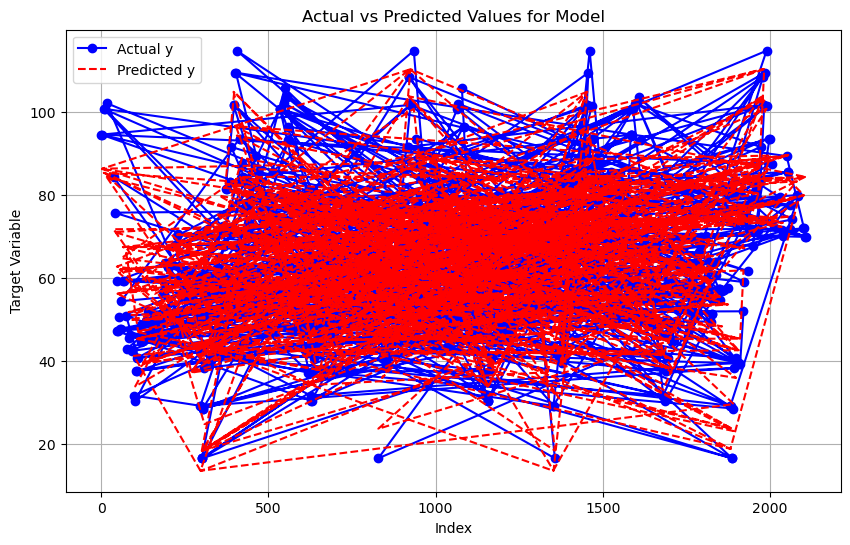

In [54]:

df_graph = pd.DataFrame({'actual_y': y_test_m, 'predicted_y': predicted_y_values_m})
plt.figure(figsize=(10, 6))
plt.plot(df_graph.index, df_graph['actual_y'], label='Actual y', color='blue', marker='o')
plt.plot(df_graph.index, df_graph['predicted_y'], label='Predicted y', color='red', linestyle='--')
plt.title('Actual vs Predicted Values for Model')
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.legend()
plt.grid()
plt.show()

### Use the scaled X, y in model

In [38]:
# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()
y_scaler =skl.preprocessing.StandardScaler()

X_scaler.fit(X_train_t)
y_scaler.fit(y_train_t.values.reshape(-1, 1))  

# Scale the data
X_train_scaled = X_scaler.transform(X_train_t)
X_test_scaled = X_scaler.transform(X_test_t)
y_train_scaled = y_scaler.transform(y_train_t.values.reshape(-1, 1)).flatten()  
y_test_scaled = y_scaler.transform(y_test_t.values.reshape(-1, 1)).flatten() 

In [39]:
#create linear model with scaled X, y
model_scaled = LinearRegression()

# Fit the model using the scaled data
model_scaled.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [40]:
# Make predictions on the scaled test data
y_pred_scaled = model_scaled.predict(X_test_scaled)

# Inverse transform the predictions to get them back to the original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()



In [41]:
#Evaluate the scaled model
mse_2 = mean_squared_error(y_test_t, y_pred)
r2_2 = r2_score(y_test_t, y_pred)

print(f'Mean Squared Error: {mse_2}')
print(f'R-squared: {r2_2}')

Mean Squared Error: 81.83307623776466
R-squared: 0.8078024458660626


the scaling dosnt improve the model performance as the meausrement of the dataset mostly is measured in percentage. Therefore the scaling is not the way to improve the model performance.

### Use Prophet model to forcest the time series change 

In [42]:
from prophet import Prophet

In [43]:
crude_oil_fed.head()

,Year,Month,WTI,Inflation,Ten_Year_Bond_Yield,Federal Rate
0,2014,1,94.6200000000,2.22619,2.86000,0.07161
1,2014,1,94.6200000000,2.22619,2.86000,0.07161
2,2014,1,94.6200000000,2.22619,2.86000,0.07161
3,2014,1,94.6200000000,2.22619,2.86000,0.07161
4,2014,2,100.8200000000,2.15737,2.71000,0.06643


In [44]:
#prepare the data for Prophet
crude_oil_fed['Date'] = pd.to_datetime(crude_oil_fed[['Year', 'Month']].assign(Day=1))
df = crude_oil_fed[['Date','WTI']]
df.rename(columns={'Date': 'ds', 'WTI': 'y'}, inplace=True)

/var/folders/bv/2fdttk8n7tzd3smj9m7vrf480000gn/T/ipykernel_79582/3009206182.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Date': 'ds', 'WTI': 'y'}, inplace=True)


In [45]:
# define the model
model_pro = Prophet()
# fit the model
model_pro.fit(df)

16:00:41 - cmdstanpy - INFO - Chain [1] start processing
16:00:41 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
# create test dataset, remove last five years(60 months)
train = df.drop(df.index[-60:])
test = df.iloc[-60:]


In [47]:
# use the model to make a forecast
forecast = model_pro.predict(test[['ds']])

In [48]:
#Evaluate the prophet model
y_true_pro = df['y'][-60:].values
y_pred_pro = forecast['yhat'].values

mse_pro = mean_squared_error(y_true_pro, y_pred_pro)
r2_pro = r2_score(y_true_pro, y_pred_pro)

print(f'Mean Squared Error: {mse_pro}')
print(f'R-squared: {r2_pro}')

Mean Squared Error: 15.619641482746484
R-squared: 0.4215528045748759


# Build Model for WCS prediction

## Data Preparation

In [ ]:
#copy the crude_oil_cad dataframe and and a column t to record time serial
crude_oil_cad_t =crude_oil_cad.copy()
crude_oil_cad_t['t'] = range(1, len(crude_oil_cad_t) + 1)
crude_oil_cad_t.drop(crude_oil_cad_t[crude_oil_cad_t['Inflation'] > 100].index, inplace=True)
crude_oil_cad_t.head()


,Year,Month,WCS,Inflation,Ten_Year_Bond_Yield,Overnight Rate,Date,t
0,2014,1,65.69000,1.30000,2.53409,0.99975,2014-01-01,1
2,2014,1,65.69000,1.30000,2.53409,0.99975,2014-01-01,3
4,2014,1,65.69000,1.30000,2.53409,0.99975,2014-01-01,5
6,2014,1,65.69000,1.30000,2.53409,0.99975,2014-01-01,7
8,2014,2,81.54000,1.30000,2.42000,0.99816,2014-02-01,9


In [ ]:
#seperate X and target y
y_t2=crude_oil_cad_t['WCS']
X_t2 = crude_oil_cad_t.drop(columns=['WCS', 'Year', 'Month','Date'])
X_t2.head()

,Inflation,Ten_Year_Bond_Yield,Overnight Rate,t
0,1.30000,2.53409,0.99975,1
2,1.30000,2.53409,0.99975,3
4,1.30000,2.53409,0.99975,5
6,1.30000,2.53409,0.99975,7
8,1.30000,2.42000,0.99816,9


In [ ]:
from sklearn.model_selection import train_test_split

X_train_t2, X_test_t2, y_train_t2, y_test_t2 = train_test_split(X_t2, 
                                                    y_t2, 
                                                    random_state=1)
X_train_t2.shape

(1584, 4)

In [ ]:
print(X_train_t2.isnull().sum())


Inflation              0
Ten_Year_Bond_Yield    0
Overnight Rate         0
t                      0
dtype: int64


## Build Liner regression

In [ ]:
#create a liner regression model
model_t2=LinearRegression()
model_t2.fit(X_train_t2,y_train_t2)

LinearRegression()

In [ ]:
print(f"Model's slope: {model_t2.coef_}")
print(f"Model's y-intercept: {model_t2.intercept_}")

Model's slope: [ 3.01681547e+00  2.45852059e+01 -8.92922083e+00  2.27797271e-04]
Model's y-intercept: 6.140577775167472


In [ ]:
predicted_y_values_t2=model_t2.predict(X_test_t2)
mse_t2 = mean_squared_error(y_test_t2, predicted_y_values_t2)
r2_t2 = r2_score(y_test_t2, predicted_y_values_t2)
rmse_t2= np.sqrt(mse)

print(f'Mean Squared Error: {mse_t2}')
print(f'R² Score: {r2_t2}')
print(f"The root mean squared error is {rmse_t2}.")


Mean Squared Error: 162.4178391257488
R² Score: 0.5819066351294225
The root mean squared error is 9.05057508189863.


### remove the time factor t in the model instead use month

In [ ]:
#seperate X and target y
y_t3=crude_oil_cad_t['WCS']
X_t3 = X_t2.drop(columns=['t'])
X_t3['Month'] = crude_oil_cad['Month']

In [ ]:
from sklearn.model_selection import train_test_split

X_train_t3, X_test_t3, y_train_t3, y_test_t3 = train_test_split(X_t3, 
                                                    y_t3, 
                                                    random_state=1)
X_train_t3.shape

(1584, 4)

In [ ]:
#create a liner regression model
model_t3=LinearRegression()
model_t3.fit(X_train_t3,y_train_t3)

LinearRegression()

In [ ]:
print(f"Model's slope: {model_t3.coef_}")
print(f"Model's y-intercept: {model_t3.intercept_}")

Model's slope: [ 3.03857077 24.49264221 -8.82461959 -0.32579016]
Model's y-intercept: 8.724313834937377


In [ ]:
predicted_y_values_t3=model_t3.predict(X_test_t3)
mse_t3 = mean_squared_error(y_test_t3, predicted_y_values_t3)
r2_t3 = r2_score(y_test_t3, predicted_y_values_t3)
rmse_t3= np.sqrt(mse_t3)

print(f'Mean Squared Error: {mse_t3}')
print(f'R² Score: {r2_t3}')
print(f"The root mean squared error is {rmse_t3}.")

Mean Squared Error: 163.38982790683136
R² Score: 0.5794045573879214
The root mean squared error is 12.782403056813353.


## Add the column to show the change of WCS and create model to predict the change

In [ ]:
# Calculate the difference
crude_oil_cad_2=crude_oil_cad.copy()
crude_oil_cad_2['WCS_Change'] = crude_oil_cad_2['WCS'].diff()

# Create the dummy column to show the change of WCS, and 1 means increase and 0 means decrease
crude_oil_cad_2['WCS_Increase'] = (crude_oil_cad_2['WCS_Change'] > 0).astype(int)

# drop the WCS_Change column 
crude_oil_cad_2.drop(columns=['WCS_Change'], inplace=True)
crude_oil_cad_2.drop(crude_oil_cad_2[crude_oil_cad_2['Inflation'] > 100].index, inplace=True)
crude_oil_cad_2.reset_index(drop=True, inplace=True)


In [ ]:
crude_oil_cad_2.head()

,Year,Month,WCS,Inflation,Ten_Year_Bond_Yield,Overnight Rate,Date,WCS_Increase
0,2014,1,65.69000,1.30000,2.53409,0.99975,2014-01-01,0
1,2014,1,65.69000,1.30000,2.53409,0.99975,2014-01-01,0
2,2014,1,65.69000,1.30000,2.53409,0.99975,2014-01-01,0
3,2014,1,65.69000,1.30000,2.53409,0.99975,2014-01-01,0
4,2014,2,81.54000,1.30000,2.42000,0.99816,2014-02-01,1


### create LogisticRegression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# Define features (X) and target (y)
y_lr = crude_oil_cad_2['WCS_Increase']
X_lr = crude_oil_cad_2.drop(columns=['Date', 'Year', 'WCS'])


In [ ]:
# Split the data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, random_state=2)

# Create and train the model
model_lr = LogisticRegression()
model_lr.fit(X_train_lr, y_train_lr)

LogisticRegression()

In [ ]:
# Make predictions
y_pred_lr = model_lr.predict(X_test_lr)

# Evaluate the model
print(confusion_matrix(y_test_lr, y_pred_lr))
print(classification_report(y_test_lr, y_pred_lr))

[[444   0]
 [  0  84]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       444
           1       1.00      1.00      1.00        84

    accuracy                           1.00       528
   macro avg       1.00      1.00      1.00       528
weighted avg       1.00      1.00      1.00       528

